# 1. Import and Install Dependencies

In [ ]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          ) 
    # # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
cap = cv2.VideoCapture(1)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/tamtran/miniconda3/envs/asl/lib/python3.9/site-packages/cv2/qt/plugins"


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [7]:
    cap.release()
    cv2.destroyAllWindows()

# 3. Extract Keypoint Values

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

In [9]:
extract_keypoints(results).shape

(258,)

# 4. Setup Folders for Collection

In [35]:
# Actions that we try to detect
actions = np.array(['how much'])

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('./MP_Data') 

# Thirty videos worth of data
no_sequences = 80

# Videos are going to be 30 frames in length
sequence_length = 24

for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [36]:
cap = cv2.VideoCapture(0)
stop = False
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#               print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION {}'.format(action), (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {} Frame {}'.format(action, sequence, frame_num), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {} Frame {}'.format(action, sequence, frame_num), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    stop = True
                    break
            if stop:
                break
        if stop:
            break
                
    cap.release()
    cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x5594951af4a0) is not the object's thread (0x5594950c5c60).
Cannot move to target thread (0x5594951af4a0)

QObject::moveToThread: Current thread (0x5594951af4a0) is not the object's thread (0x5594950c5c60).
Cannot move to target thread (0x5594951af4a0)

QObject::moveToThread: Current thread (0x5594951af4a0) is not the object's thread (0x5594950c5c60).
Cannot move to target thread (0x5594951af4a0)

QObject::moveToThread: Current thread (0x5594951af4a0) is not the object's thread (0x5594950c5c60).
Cannot move to target thread (0x5594951af4a0)

QObject::moveToThread: Current thread (0x5594951af4a0) is not the object's thread (0x5594950c5c60).
Cannot move to target thread (0x5594951af4a0)

QObject::moveToThread: Current thread (0x5594951af4a0) is not the object's thread (0x5594950c5c60).
Cannot move to target thread (0x5594951af4a0)

QObject::moveToThread: Current thread (0x5594951af4a0) is not the object's thread (0x5594950c5c60).
Cannot move to tar

In [1]:
import cv2
cap = cv2.VideoCapture(0)
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [38]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [7]:
actions = os.listdir('./MP_Data')
actions = np.array(actions)

In [8]:
label_map = {label:num for num, label in enumerate(actions)}

In [41]:
label_map

{'hello': 0,
 'how much': 1,
 'thank you': 2,
 'bye': 3,
 'you': 4,
 'happy': 5,
 'hungry': 6,
 'good job': 7,
 'sad': 8,
 'father': 9,
 'i love you': 10}

In [42]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [43]:
X = np.array(sequences)

In [44]:
y = to_categorical(labels).astype(int)

In [77]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [79]:
y_test.shape

(88, 11)

# 7. Build and Train LSTM Neural Network

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
import tensorflow as tf

In [47]:
log_dir = os.path.join('Logs')
tb_callback = [
    TensorBoard(log_dir=log_dir),
    ReduceLROnPlateau(factor=0.1, patience=5)
]

2021-10-14 16:41:26.527215: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-14 16:41:26.527269: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-14 16:41:26.527960: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [48]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(24,258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 24, 64)            82688     
_________________________________________________________________
lstm_7 (LSTM)                (None, 24, 128)           98816     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 11)               

In [50]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
history = model.fit(X_train, y_train, 
                        epochs=40, 
                        callbacks=[tb_callback],
                        validation_data = (X_test, y_test))

Epoch 1/40
 2/25 [=>............................] - ETA: 11s - loss: 2.4040 - accuracy: 0.0781 

2021-10-14 16:41:44.161742: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-14 16:41:44.161804: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-14 16:41:44.346871: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-14 16:41:44.403957: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-14 16:41:44.534263: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: Logs/train/plugins/profile/2021_10_14_16_41_44

2021-10-14 16:41:44.599707: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to Logs/train/plugins/profile/2021_10_14_16_41_44/TranTran.trace.json.gz


 3/25 [==>...........................] - ETA: 10s - loss: 2.4058 - accuracy: 0.0625

2021-10-14 16:41:44.659213: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: Logs/train/plugins/profile/2021_10_14_16_41_44

2021-10-14 16:41:44.659464: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to Logs/train/plugins/profile/2021_10_14_16_41_44/TranTran.memory_profile.json.gz
2021-10-14 16:41:44.663013: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: Logs/train/plugins/profile/2021_10_14_16_41_44
Dumped tool data for xplane.pb to Logs/train/plugins/profile/2021_10_14_16_41_44/TranTran.xplane.pb
Dumped tool data for overview_page.pb to Logs/train/plugins/profile/2021_10_14_16_41_44/TranTran.overview_page.pb
Dumped tool data for input_pipeline.pb to Logs/train/plugins/profile/2021_10_14_16_41_44/TranTran.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to Logs/train/plugins/profile/2021_10_14_16_41_44/TranTran.tensorflow_stats.pb
Dumped tool data 

25/25 [==============================] - 14s 294ms/step - loss: 2.3717 - accuracy: 0.1061 - val_loss: 2.3115 - val_accuracy: 0.1705
Epoch 2/40
25/25 [==============================] - 4s 140ms/step - loss: 2.2701 - accuracy: 0.1477 - val_loss: 2.1156 - val_accuracy: 0.1818
Epoch 3/40
25/25 [==============================] - 3s 134ms/step - loss: 2.1289 - accuracy: 0.2172 - val_loss: 1.9829 - val_accuracy: 0.2500
Epoch 4/40
25/25 [==============================] - 4s 140ms/step - loss: 1.9891 - accuracy: 0.2563 - val_loss: 1.7849 - val_accuracy: 0.3977
Epoch 5/40
25/25 [==============================] - 3s 133ms/step - loss: 1.8082 - accuracy: 0.3270 - val_loss: 1.5948 - val_accuracy: 0.4886
Epoch 6/40
25/25 [==============================] - 4s 144ms/step - loss: 1.5834 - accuracy: 0.4318 - val_loss: 1.4286 - val_accuracy: 0.5682
Epoch 7/40
25/25 [==============================] - 3s 136ms/step - loss: 1.3834 - accuracy: 0.5088 - val_loss: 1.2199 - val_accuracy: 0.6023
Epoch 8/40
25/25

Text(0.5, 1.0, 'Training and Validation Loss')

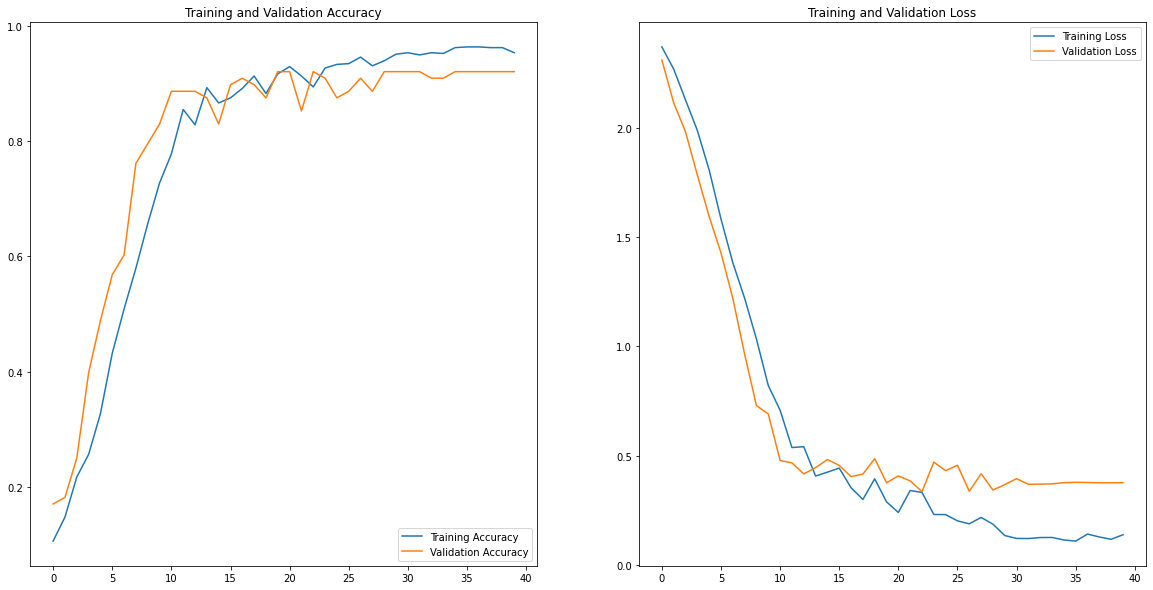

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = history.epoch

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# 8. Make Predictions

In [91]:
res = model.predict(X_test)

In [96]:
actions[np.argmax(res[11])]

'bye'

In [97]:
actions[np.argmax(y_test[11])]

'bye'

# 9. Save Weights

In [53]:
model.save('model_thirdrun.h5')

In [ ]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [9]:
import tensorflow as tf

2021-10-15 10:25:15.515194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-15 10:25:15.515238: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
# Load model:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('./model_thirdrun.h5')

# Show the model architecture
model.summary()

# We need to define its optimizer and loss function again since the h5 file
# does not contain those information :(
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

2021-10-15 10:25:30.558613: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-15 10:25:30.558684: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-15 10:25:30.558754: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (TranTran): /proc/driver/nvidia/version does not exist


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 24, 64)            82688     
_________________________________________________________________
lstm_7 (LSTM)                (None, 24, 128)           98816     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 11)               

In [11]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

In [91]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [92]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[2, 0],
        [0, 3]],

       [[4, 0],
        [0, 1]],

       [[4, 0],
        [0, 1]]], dtype=int64)

In [93]:
accuracy_score(ytrue, yhat)

1.0

# 11. Text to speak

In [5]:
!pip install pyttsx3

In [12]:
import pyttsx3

engine = pyttsx3.init()
engine.say('see you later')
engine.runAndWait()

In [62]:
# Show all language
voice_lang = {idx: str(voice.languages[0]).split('5')[-1] for idx, voice in enumerate(voices)}
print(voice_lang)


{0: "af'", 1: "an'", 2: "bg'", 3: "bs'", 4: "ca'", 5: "cs'", 6: "cy'", 7: "da'", 8: "de'", 9: "el'", 10: "en'", 11: "b'\\x02en-gb'", 12: "en-sc'", 13: "en-uk-north'", 14: "en-uk-rp'", 15: "en-uk-wmids'", 16: "b'\\x02en-us'", 17: "en-wi'", 18: "eo'", 19: "es'", 20: "es-la'", 21: "et'", 22: "fa'", 23: "fa-pin'", 24: "fi'", 25: "fr-be'", 26: "fr-fr'", 27: "ga'", 28: "grc'", 29: "hi'", 30: "hr'", 31: "hu'", 32: "hy'", 33: "hy-west'", 34: "id'", 35: "is'", 36: "it'", 37: "jbo'", 38: "ka'", 39: "kn'", 40: "ku'", 41: "la'", 42: "lfn'", 43: "lt'", 44: "lv'", 45: "mk'", 46: "ml'", 47: "ms'", 48: "ne'", 49: "nl'", 50: "no'", 51: "pa'", 52: "pl'", 53: "pt-br'", 54: "pt-pt'", 55: "ro'", 56: "ru'", 57: "sk'", 58: "sq'", 59: "sr'", 60: "sv'", 61: "sw'", 62: "ta'", 63: "tr'", 64: "vi'", 65: "vi-hue'", 66: "vi-sgn'", 67: "zh'", 68: "zh-yue'"}


In [16]:
engine = pyttsx3.init()
voices = engine.getProperty('voices')
engine.setProperty('voice', voices[16].id)
engine.say('hello')
engine.runAndWait()

# 12. Test in Real Time

In [87]:
res.sort()

In [ ]:
pred_dict = dict(zip(actions, res))
prediction = sorted(pred_dict.items(), key=lambda x: x[1])[::-1]
prediction

In [19]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()

    pred_dict = dict(zip(actions, res))
    # sorting for prediction and get top 5
    prediction = sorted(pred_dict.items(), key=lambda x: x[1])[::-1][:5]

    for num, pred in enumerate(prediction):
        text = '{}: {}'.format(pred[0], pred[1])
        # cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, text, (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)
        
    return output_frame

In [47]:
# New detection variables
sequence = []
sentence = []
threshold = 0.9
tts = False

# Text to speak config:
engine = pyttsx3.init()
voices = engine.getProperty('voices')
engine.setProperty('voice', voices[16].id)

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)

        # sequence.insert(0,keypoints)
        # sequence = sequence[:24]
        sequence.append(keypoints)
        sequence = sequence[-24:]
        
        if len(sequence) == 24:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]

            #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                        tts = True
                else:
                    sentence.append(actions[np.argmax(res)])
                    tts = True

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)

            # Text to speak:
            if tts:
                engine.say(sentence[-1])
                tts = False
            engine.runAndWait()
            
            # 
            cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3,30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x556dd59b4380) is not the object's thread (0x556dd5e12c30).
Cannot move to target thread (0x556dd59b4380)

QObject::moveToThread: Current thread (0x556dd59b4380) is not the object's thread (0x556dd5e12c30).
Cannot move to target thread (0x556dd59b4380)

QObject::moveToThread: Current thread (0x556dd59b4380) is not the object's thread (0x556dd5e12c30).
Cannot move to target thread (0x556dd59b4380)

QObject::moveToThread: Current thread (0x556dd59b4380) is not the object's thread (0x556dd5e12c30).
Cannot move to target thread (0x556dd59b4380)

QObject::moveToThread: Current thread (0x556dd59b4380) is not the object's thread (0x556dd5e12c30).
Cannot move to target thread (0x556dd59b4380)

QObject::moveToThread: Current thread (0x556dd59b4380) is not the object's thread (0x556dd5e12c30).
Cannot move to target thread (0x556dd59b4380)

QObject::moveToThread: Current thread (0x556dd59b4380) is not the object's thread (0x556dd5e12c30).
Cannot move to tar

## Check have 2 hands or not

In [44]:
# New detection variables
sequence = []
sentence = []
threshold = 0.87
tts = False

# Text to speak config:
engine = pyttsx3.init()
voices = engine.getProperty('voices')
engine.setProperty('voice', voices[16].id)

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        # Check have 2 hands or not:
        # results.right_hand_landmarks.landmark
        keypoints = extract_keypoints(results)

        sequence.append(keypoints)
        sequence = sequence[-24:]

        if len(sequence) == 24:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]

            #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                        tts = True
                else:
                    sentence.append(actions[np.argmax(res)])
                    tts = True

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)

            # Text to speak:
            if tts:
                engine.say(sentence[-1])
                tts = False
            engine.runAndWait()

            cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3,30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        image = prob_viz(res, actions, image, colors)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

KeyboardInterrupt: 

In [46]:
cap.release()
cv2.destroyAllWindows()

In [247]:
res[np.argmax(res)] > threshold

True

In [ ]:
(num_sequences,30,1662)

In [240]:
model.predict(np.expand_dims(X_test[0], axis=0))

array([[5.532469e-04, 9.974770e-01, 1.969744e-03]], dtype=float32)